In [11]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import linear_model, neighbors, ensemble, naive_bayes, svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn import preprocessing

from imblearn.over_sampling import SMOTE, SMOTENC

import plotly
plotly.tools.set_credentials_file(username='extralime', api_key='q3tUGZrv40fkKyR4uPuL')
import plotly.plotly as py
import plotly.graph_objs as go
import colorlover as cl

from IPython.display import Image
from IPython.display import HTML

import warnings

warnings.filterwarnings(
    module='scipy',
    action='ignore',
    message='Using a')

def model_me(X_train,X_test, y_train, y_test):
    knn = neighbors.KNeighborsClassifier(n_neighbors=10, weights='distance')
    knn.fit(X_train,y_train)
    y_pred = knn.predict(X_test)
    print('Results of KNN:\n')
    print('\nClassification Report:KNN\n')
    print(classification_report(y_test,y_pred))
    print('Confusion Matrix:')
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cbar=False)
    plt.show()
    print('ROC_AUC _SCORE:')
    print(roc_auc_score(y_test,y_pred))
    rfc = ensemble.RandomForestClassifier(n_estimators=250, class_weight='balanced',criterion='entropy')
    rfc.fit(X_train,y_train)
    y_pred = rfc.predict(X_test)
    print('\n\nResults of Random Forest:\n')
    print('\nClassification Report:RFC\n')
    print(classification_report(y_test,y_pred))
    print('Confusion Matrix:')
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cbar=False)
    plt.show()
    print('ROC_AUC _SCORE:')
    print(roc_auc_score(y_test,y_pred))
    
    lrc = linear_model.LogisticRegression(C=10, penalty='l1')
    lrc.fit(X_train,y_train)
    y_pred = lrc.predict(X_test)
    print('\n\nResults of Logistic Regression (lasso):\n')
    print('\nClassification Report:LR1\n')
    print(classification_report(y_test,y_pred))
    print('Confusion Matrix:')
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cbar=False)
    plt.show()
    print('ROC_AUC _SCORE:')
    print(roc_auc_score(y_test,y_pred))
    lrc = linear_model.LogisticRegression(C=10, penalty='l2')
    lrc.fit(X_train,y_train)
    y_pred = lrc.predict(X_test)
    print('\n\nResults of Logistic Regression (Ridge):\n')
    print('\nClassification Report:LR2\n')
    print(classification_report(y_test,y_pred))
    print('Confusion Matrix:')
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cbar=False)
    plt.show()
    print('ROC_AUC _SCORE:')
    print(roc_auc_score(y_test,y_pred))
    gbc = ensemble.GradientBoostingClassifier(n_estimators=500,max_depth=4,loss='exponential')
    gbc.fit(X_train,y_train)
    y_pred = gbc.predict(X_test)
    print('\n\nResults of Gradient Boosting:\n')
    print('\nClassification Report:GBC\n')
    print(classification_report(y_test,y_pred))
    print('Confusion Matrix:')
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='d',cbar=False)
    plt.show()
    print('ROC_AUC _SCORE:')
    print(roc_auc_score(y_test,y_pred))


colors = cl.to_rgb(cl.scales['10']['div']['BrBG'])
HTML(cl.to_html( cl.scales['10']['div']['BrBG'] ))

In [12]:
#import the data, manage nulls and date field
df = pd.read_csv('lemon_train.csv')

df.PurchDate = pd.to_datetime(df.PurchDate)
df['pyear'] = df['PurchDate'].dt.year.astype(int)
df['pmonth'] = df['PurchDate'].dt.month.astype(int)
df['pday'] = df['PurchDate'].dt.day.astype(int)
#Drop the date and other columns
df.drop(['RefId', 'BYRNO', 'AUCGUART', 'PRIMEUNIT',
         'VNZIP1','WheelType', 'VehYear','PurchDate'],1,inplace=True)
df.dropna(inplace=True)
#add 1 to vehicle age (for math)
df.VehicleAge = [x+1 for x in df.VehicleAge]
df.shape


(67275, 29)

### Create dummy variables for extracted keyword from problematic categorical variables

In [13]:
#Separate and combine columns of interest
models = df.Model
submods = df.SubModel
trims = df.Trim
chars = df[['Model','SubModel','Trim']] 

#keyword list for model characteristics
mod_chars = ['2WD','V6','4C','PICKUP','6C','FWD',
             '4WD','AWD','SFI','EFI','DOHC','I4','MPI']

#keyowrd list for submodel characteristics
submod_chars = ['SEDAN','4D','EXT','CAB','2D','CAB','WAGON',
                'REG','FFV','PASSENGER','SUV','SPORT',
                'UTILITY','QUAD','COUPE','MINIVAN','CUV']

#Create a dataframe and extract keywords from model and submodel.
sub_val_sets, mod_val_sets = pd.DataFrame(),pd.DataFrame()

for key in submod_chars:
    subs = np.where(submods.str.contains(key),1,0) #create array for dummied char prescence    
    sub_val_sets[key] = subs #insert to dataframe
for key in mod_chars:
    mods = np.where(models.str.contains(key),1,0)
    mod_val_sets[key] = mods


In [14]:
#combine the two characteristic sets
char_dummies = pd.concat([mod_val_sets,sub_val_sets],axis=1)  

# Extract engine displacement sizes

In [15]:
displacement = chars.SubModel.str.split('.').reset_index()
disp_ok = []
#Only keep entries with engine size len(Submodel) == 2
for model in displacement.SubModel:
    if len(model) == 2:
        disp_ok.append(model)
        
#Finally take the last element from 1st list, insert '.' add lasr element of 2nd list
displacements = []
for i in range(len(disp_ok)):
    beg = disp_ok[i][0][-1]
    end = disp_ok[i][1][0]
    whole = beg+'.'+end
    displacements.append(whole)
displacements = pd.Series(displacements)
ds_val_cnts = displacements.value_counts().reset_index()

In [16]:
#create dummie matrix for engine displacements
disp_keys = pd.DataFrame()
for key in ds_val_cnts['index']:
    dsps = np.where(df.SubModel.str.contains(key),1,0) #create array for dummied char prescence    
    disp_keys[key] = dsps #insert to dataframe

# examining our features

## Expirementing with the continuous data


In [17]:
#combine the three new dataframes
mod_val_sets.reset_index(drop=True,inplace=True)
sub_val_sets.reset_index(drop=True,inplace=True)
disp_keys.reset_index(drop=True,inplace=True)

dummy_feats = pd.concat([mod_val_sets,sub_val_sets,disp_keys],axis=1)

In [18]:
dummy_feats['IsBadBuy'] = df.IsBadBuy
dummy_feats.columns

Index(['2WD', 'V6', '4C', 'PICKUP', '6C', 'FWD', '4WD', 'AWD', 'SFI', 'EFI',
       'DOHC', 'I4', 'MPI', 'SEDAN', '4D', 'EXT', 'CAB', '2D', 'WAGON', 'REG',
       'FFV', 'PASSENGER', 'SUV', 'SPORT', 'UTILITY', 'QUAD', 'COUPE',
       'MINIVAN', 'CUV', '3.5', '4.2', '3.3', '4.7', '3.0', '3.9', '2.2',
       '2.7', '4.6', '3.8', '5.3', '4.0', '3.7', '5.7', '5.4', '3.4', '4.8',
       '2.3', '4.3', '2.4', '1.8', '2.5', '5.6', '2.8', '2.0', '5.9', '6.0',
       '3.6', '2.9', '8.1', '5.2', 'IsBadBuy'],
      dtype='object')

In [19]:
cols = []
odds_of_zero = []
present = []
pct_lemons = []
variance = []


#loop to compare the odds of getting rating = 0 vs rating 1
for col in dummy_feats.loc[:, ~(dummy_feats.columns).isin(['IsBadBuy'])]:
    variance.append(dummy_feats[col].mean())
    odds = dummy_feats.loc[dummy_feats[col]==1] #locate entries where attribute value is 1
    cols.append(col)#append the attribute name
    present.append(len(odds.IsBadBuy))#the occurance of attribute
    pct_lemons.append(odds.IsBadBuy.mean())#percent good recipes when attribute present
    #in the case of zero occurance of good ratings
    if odds.IsBadBuy.sum() == 0:
        odds_of_zero.append(100)
    # if sum() not 0, calculate odds.
    if odds.IsBadBuy.sum() != 0:
        that = len(odds.IsBadBuy)-odds.IsBadBuy.sum()
        this = odds.IsBadBuy.sum()
        odds_of_zero.append(that/this)

In [20]:
pdf = pd.DataFrame()
pdf['col'] = cols
pdf['odds_of_zero'] = odds_of_zero
pdf['present'] = present
pdf['variance'] = variance
pdf['pct_lemons'] = pct_lemons


In [21]:
pdf.head(1)

,col,odds_of_zero,present,variance,pct_lemons
0,2WD,10.21317,10047,0.149342,0.096521


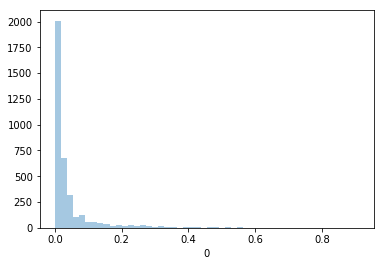

,level_0,level_1,0
979,CAB,PICKUP,0.911305
199,PICKUP,CAB,0.911305
1603,COUPE,2D,0.872834
1063,2D,COUPE,0.872834
1918,3.3,MINIVAN,0.843722


In [22]:
corrmat = dummy_feats.corr().abs()#create correlation matrix
c = corrmat.unstack().reset_index()
#take a look at the distribution of the higher correlated pairs.

#plot a histogram
fig = sns.distplot(c[c[0] != 1][0],kde=False,bins=50)
plt.show()
c[c != 1].sort_values(by=0,ascending=False).head(5)

In [23]:
d = c.loc[(c[0]!=1) & (c[0]>.5)]
d = d.rename(columns={0:'corr'})
d.head(3)


,level_0,level_1,corr
199,PICKUP,CAB,0.911305
208,PICKUP,QUAD,0.528252
274,6C,4.2,0.829285


In [24]:
corrgroup = d.groupby('level_0')['level_1'].value_counts()
pdf['n_corrs>.5'] = corrgroup.groupby('level_0').describe().reset_index()['count']
corrgroup = d.groupby('level_0')['level_1'].value_counts()
pdf['avg_corr'] = d.groupby('level_0')['corr'].mean().reset_index()['corr']
pdf.fillna(0,inplace=True)

In [25]:
'''#A quick visuaization,
sns.set_style('darkgrid')
g = sns.PairGrid(pdf, diag_sharey=False)

g.map_upper(plt.scatter, alpha=.5)

g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

g.map_diag(sns.kdeplot, lw=3)
plt.show()
'''


"#A quick visuaization,\nsns.set_style('darkgrid')\ng = sns.PairGrid(pdf, diag_sharey=False)\n\ng.map_upper(plt.scatter, alpha=.5)\n\ng.map_lower(sns.regplot, scatter_kws=dict(alpha=0))\n\ng.map_diag(sns.kdeplot, lw=3)\nplt.show()\n"

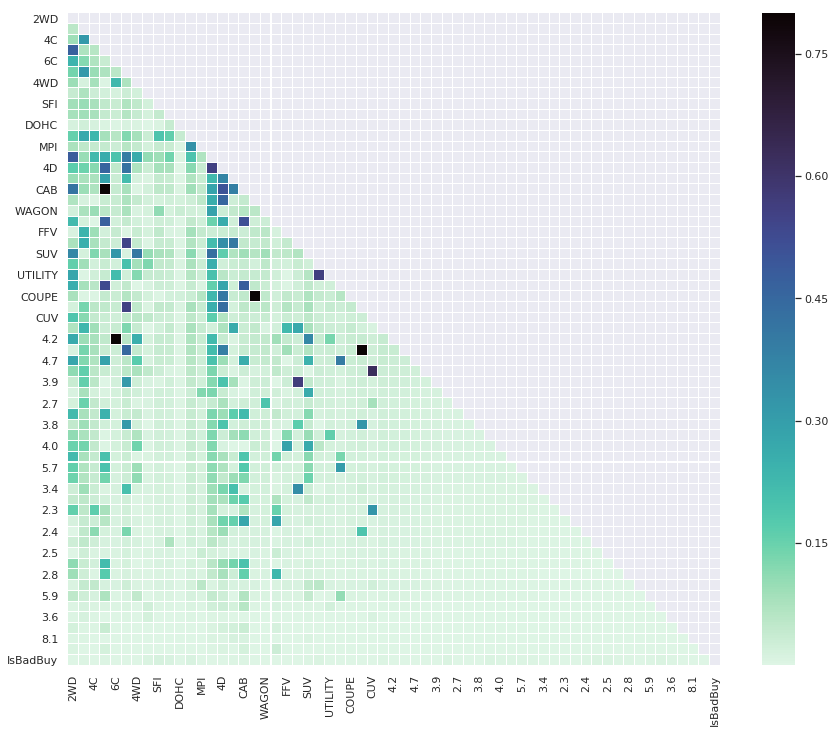

In [26]:
sns.set(palette='YlGnBu')
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
    
with sns.axes_style('dark'):    
    ax = plt.subplots(figsize=(15,12))

    sns.heatmap(corrmat,
            vmax=.8, 
            cmap="mako_r",
            annot=False,
            linewidth=.02,
            square=True,
            mask=mask)


plt.show()

In [27]:
#subtract everything from everything
plodf= df[['MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice',
 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice',
 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice',
 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice',
 'VehicleAge','VehOdo','WarrantyCost','IsBadBuy']].copy()
plodf.dropna(inplace=True)
plodf['crcp_cacp'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRCurrentAuctionCleanPrice
plodf['arcp_aacp'] = plodf.MMRAcquisitonRetailCleanPrice - plodf.MMRAcquisitionAuctionCleanPrice
plodf['crap_caap'] = plodf.MMRCurrentRetailAveragePrice - plodf.MMRCurrentAuctionAveragePrice
plodf['arap_aaap'] = plodf.MMRAcquisitionRetailAveragePrice - plodf.MMRAcquisitionAuctionAveragePrice

plodf['caap_aaap'] = plodf.MMRCurrentAuctionAveragePrice - plodf.MMRAcquisitionAuctionAveragePrice
plodf['cacp_aacp'] = plodf.MMRCurrentAuctionCleanPrice - plodf.MMRAcquisitionAuctionCleanPrice
plodf['crap_arap'] = plodf.MMRCurrentRetailAveragePrice - plodf.MMRAcquisitionRetailAveragePrice
plodf['crcp_arcp'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRAcquisitonRetailCleanPrice

plodf['crcp_crap'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRCurrentRetailAveragePrice
plodf['arcp_arap'] = plodf.MMRAcquisitonRetailCleanPrice - plodf.MMRAcquisitionRetailAveragePrice
plodf['cacp_caap'] = plodf.MMRCurrentAuctionCleanPrice - plodf.MMRCurrentAuctionAveragePrice
plodf['aacp_aaap'] = plodf.MMRAcquisitionAuctionCleanPrice - plodf.MMRAcquisitionAuctionAveragePrice

plodf['crcp_caap'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRCurrentAuctionAveragePrice
plodf['arcp_aaap'] = plodf.MMRAcquisitonRetailCleanPrice - plodf.MMRAcquisitionAuctionAveragePrice
plodf['crap_cacp'] = plodf.MMRCurrentRetailAveragePrice - plodf.MMRCurrentAuctionCleanPrice
plodf['arap_aacp'] = plodf.MMRAcquisitionRetailAveragePrice - plodf.MMRAcquisitionAuctionCleanPrice

plodf['crcp_arap'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRAcquisitionRetailAveragePrice
plodf['arcp_crap'] = plodf.MMRAcquisitonRetailCleanPrice - plodf.MMRCurrentRetailAveragePrice
plodf['cacp_aaap'] = plodf.MMRCurrentAuctionCleanPrice - plodf.MMRAcquisitionAuctionAveragePrice
plodf['aacp_caap'] = plodf.MMRAcquisitionAuctionCleanPrice - plodf.MMRCurrentAuctionAveragePrice

plodf['crcp_aacp'] = plodf.MMRCurrentRetailCleanPrice - plodf.MMRAcquisitionAuctionCleanPrice
plodf['arcp_cacp'] = plodf.MMRAcquisitonRetailCleanPrice - plodf.MMRCurrentAuctionCleanPrice
plodf['crap_aaap'] = plodf.MMRCurrentRetailAveragePrice - plodf.MMRAcquisitionAuctionAveragePrice
plodf['arap_caap'] = plodf.MMRAcquisitionRetailAveragePrice - plodf.MMRCurrentAuctionAveragePrice

plodf['crcp_crap_cacp_caap'] = plodf['crcp_crap']-plodf['cacp_caap']
plodf['arcp_arap_aacp_aaap'] = plodf['arcp_arap']-plodf['aacp_aaap']

plodf['crcp_cacp_arcp_aacp'] = plodf['crcp_cacp']-plodf['arcp_aacp']
plodf['crap_caap_arap_aaap'] = plodf['crap_caap']-plodf['arap_aaap']

plodf['crcp_caap_arcp_aaap'] = plodf['crcp_caap']-plodf['arcp_aaap']
plodf['crap_cacp_arap_aacp'] = plodf['crap_cacp']-plodf['arap_aacp']

plodf['crcp_arap_arcp_crap'] = plodf['crcp_arap']-plodf['arcp_crap']
plodf['cacp_aaap_aacp_caap'] = plodf['cacp_aaap']-plodf['aacp_caap']

plodf['crcp_aacp_arcp_cacp'] = plodf['crcp_caap']-plodf['arcp_aaap']
plodf['crap_aaap_arap_caap'] = plodf['crap_cacp']-plodf['arap_aacp']

In [28]:
plodf.shape

(67275, 46)

In [29]:
plodf['crcp_cacp_war'] = plodf['crcp_cacp']* df.WarrantyCost/df.VehicleAge

In [30]:
plodf['crcp_cacp_logwar'] = plodf['crcp_cacp_war']

In [31]:
plodf['crcp_cacp_losqwar'] = plodf['crcp_cacp']* df.WarrantyCost/np.sqrt(df.VehicleAge)

In [32]:
plodf['crap_aaap_war'] = plodf['crap_aaap']* df.WarrantyCost/df.VehicleAge

In [33]:
plodf['log_war_age'] = df.WarrantyCost/df.VehicleAge

In [34]:
plodf['odo_age'] = np.log(df.VehOdo/df.VehicleAge)

In [35]:
plodf['odo_war'] = np.log((df.WarrantyCost/df.VehOdo))
plodf['another'] = np.log(df.WarrantyCost/df.VehOdo**2)
plodf['ugh'] = plodf.VehicleAge * (plodf.crcp_caap/plodf.WarrantyCost)

In [36]:
price_pvals = pd.DataFrame()
prices = []
pvals = []
for col in plodf: 
    tstat = stats.ttest_ind(
    plodf[plodf.IsBadBuy == 1][col],
    plodf[plodf.IsBadBuy == 0][col])
    prices.append(col)
    pvals.append(tstat.pvalue)
price_pvals['price'] = prices
price_pvals['pvalues'] = pvals

In [37]:
price_pvals.sort_values(by='pvalues',inplace=True)
cont_df = plodf[['odo_age','log_war_age','crcp_cacp_war']]

In [38]:
#combine the three new dataframes
mod_val_sets.reset_index(drop=True,inplace=True)
sub_val_sets.reset_index(drop=True,inplace=True)
disp_keys.reset_index(drop=True,inplace=True)
cont_df.reset_index(drop=True,inplace=True)

add_feats = pd.concat([mod_val_sets,sub_val_sets,disp_keys,cont_df],axis=1)


In [39]:
df.shape,add_feats.shape

((67275, 29), (67275, 63))

In [40]:
#combine new features to our existing attributes
df.reset_index(drop=True,inplace=True)
model_df = pd.concat([df,add_feats],axis=1)

In [41]:
model_df.drop(['SubModel'],1,inplace=True)
model_df.Model = model_df.Model.str.split().str[0].str.strip()

In [42]:
X = model_df.drop(['IsBadBuy'],1)
X = pd.get_dummies(X)

y = model_df.IsBadBuy

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4,random_state=167)

Results of KNN:


Classification Report:KNN

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     24287
           1       0.25      0.01      0.02      2623

   micro avg       0.90      0.90      0.90     26910
   macro avg       0.58      0.50      0.48     26910
weighted avg       0.84      0.90      0.86     26910

Confusion Matrix:


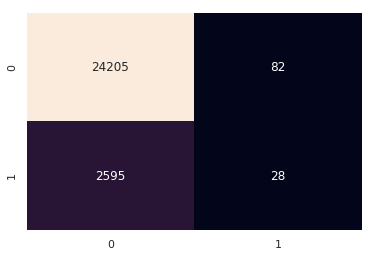

ROC_AUC _SCORE:
0.503649254002065


Results of Random Forest:


Classification Report:RFC

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     24287
           1       0.50      0.00      0.01      2623

   micro avg       0.90      0.90      0.90     26910
   macro avg       0.70      0.50      0.48     26910
weighted avg       0.86      0.90      0.86     26910

Confusion Matrix:


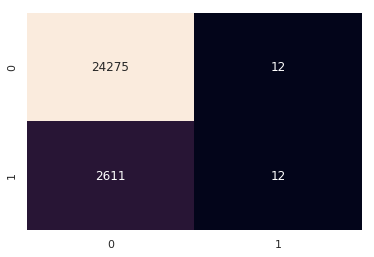

ROC_AUC _SCORE:
0.5020404113655421


/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.





Results of Logistic Regression (lasso):


Classification Report:LR1

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     24287
           1       0.26      0.01      0.01      2623

   micro avg       0.90      0.90      0.90     26910
   macro avg       0.58      0.50      0.48     26910
weighted avg       0.84      0.90      0.86     26910

Confusion Matrix:


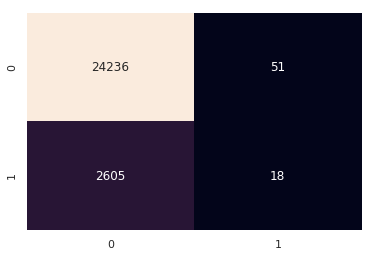

ROC_AUC _SCORE:
0.5023812412505613


/root/.pyenv/versions/3.6.0/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.





Results of Logistic Regression (Ridge):


Classification Report:LR2

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     24287
           1       0.60      0.00      0.00      2623

   micro avg       0.90      0.90      0.90     26910
   macro avg       0.75      0.50      0.48     26910
weighted avg       0.87      0.90      0.86     26910

Confusion Matrix:


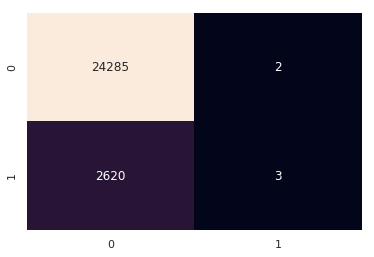

ROC_AUC _SCORE:
0.500530689986772


Results of Gradient Boosting:


Classification Report:GBC

              precision    recall  f1-score   support

           0       0.90      1.00      0.95     24287
           1       0.41      0.01      0.01      2623

   micro avg       0.90      0.90      0.90     26910
   macro avg       0.66      0.50      0.48     26910
weighted avg       0.85      0.90      0.86     26910

Confusion Matrix:


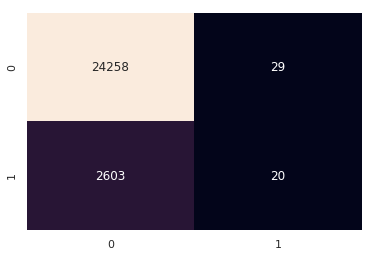

ROC_AUC _SCORE:
0.503215401300759


In [43]:
model_me(X_train, X_test, y_train, y_test)

In [44]:
rfc = ensemble.RandomForestClassifier(n_estimators=400,class_weight='balanced_subsample',max_depth = 12,criterion='entropy')
rfc.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [45]:
print(rfc.score(X_train,y_train))
y_pred = rfc.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))

0.7800817539947975
[[18545  5742]
 [ 1302  1321]]
              precision    recall  f1-score   support

           0       0.93      0.76      0.84     24287
           1       0.19      0.50      0.27      2623

   micro avg       0.74      0.74      0.74     26910
   macro avg       0.56      0.63      0.56     26910
weighted avg       0.86      0.74      0.79     26910

0.6335995147367308


In [46]:
model_dfd = pd.get_dummies(model_df)

In [47]:
model_df.dtypes

IsBadBuy                               int64
Auction                               object
VehicleAge                             int64
Make                                  object
Model                                 object
Trim                                  object
Color                                 object
Transmission                          object
WheelTypeID                          float64
VehOdo                                 int64
Nationality                           object
Size                                  object
TopThreeAmericanName                  object
MMRAcquisitionAuctionAveragePrice    float64
MMRAcquisitionAuctionCleanPrice      float64
MMRAcquisitionRetailAveragePrice     float64
MMRAcquisitonRetailCleanPrice        float64
MMRCurrentAuctionAveragePrice        float64
MMRCurrentAuctionCleanPrice          float64
MMRCurrentRetailAveragePrice         float64
MMRCurrentRetailCleanPrice           float64
VNST                                  object
VehBCost  

In [48]:
cat_list = model_df.select_dtypes(['object','int64']).index

In [55]:
scaler = preprocessing.StandardScaler()

In [71]:
X = model_df.drop(['IsBadBuy'],1)
X = pd.get_dummies(X)
#X = scaler.fit_transform(X)
y = model_df.IsBadBuy
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4,random_state=167)
sm = SMOTE(random_state=163,sampling_strategy=.3)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [72]:
X_res.shape
y_res.mean()

0.23076599326599326

In [73]:
X_train = X_res
y_train = y_res


In [74]:
rfc = ensemble.RandomForestClassifier(n_estimators=500,class_weight='balanced_subsample',max_depth = 12,criterion='entropy')
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [70]:
print(rfc.score(X_train,y_train))
y_pred = rfc.predict(X_test)
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))

0.9393681967401947
[[24119   168]
 [ 2558    65]]
              precision    recall  f1-score   support

           0       0.90      0.99      0.95     24287
           1       0.28      0.02      0.05      2623

   micro avg       0.90      0.90      0.90     26910
   macro avg       0.59      0.51      0.50     26910
weighted avg       0.84      0.90      0.86     26910

0.5089317522552185


In [79]:
this = confusion_matrix(y_test,y_pred)
this[1][0]

2558

In [ ]:
andomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='entropy', max_depth=12, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=None, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Correct Oversampling

In [98]:
X = test_mod.drop(['IsBadBuy'],1)
X = pd.get_dummies(X)
#X = scaler.fit_transform(X)
y = test_mod.IsBadBuy
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.4,random_state=167)
sm = SMOTE(random_state=163,sampling_strategy=.3)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [99]:
X_train = X_res
y_train = y_res

In [91]:
#run a loop test a number of different parameters on the same data
n_ests = []
max_d = []
min_samples_split = []
min_sam_leaf = []
TN = []
FN = []
FP = []
TP = []

for i in range(3,10,1):
    for j in range(5,13,1):
        for k in range(2,7):
            for l in range(1,6):
                params = {'n_estimators': i*100,
                      'max_depth': j,
                      'criterion': 'gini',
                      'min_samples_leaf':l,
                      'class_weight':'balanced',
                      'min_samples_split':k  }
                # Initialize and fit the model.
                clf = ensemble.RandomForestClassifier(**params)
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                # Accuracy tables.
                conf = confusion_matrix(y_test,y_pred)
                tns = conf[0][0]
                fps = conf[0][1]
                tps = conf[1][1]
                fns = conf[1][0]
                #append info
                n_ests.append(i*100)
                max_d.append(j)
                min_samples_split.append(k)
                min_sam_leaf.append(l)
                TN.append(tns)
                FN.append(fns)
                FP.append(fps)
                TP.append(tps)

In [93]:
results = pd.DataFrame()
results['n_estimates'] = n_ests
results['max_d'] = max_d
results['min_samples_split'] = min_samples_split
results['mins_samples_leaf'] = min_sam_leaf
results['TN'] = TN
results['FN'] = FN
results['FP'] = FP 
results['TP'] = TP

In [97]:
results.sort_values(by='TP',ascending=False)

,n_estimates,max_d,min_samples_split,mins_samples_leaf,TN,FN,FP,TP
9,300,5,5,1,1658,124,178,40
203,500,5,5,3,1653,124,183,40
192,500,5,2,1,1651,125,185,39
98,400,5,2,3,1644,125,192,39
103,400,5,4,2,1640,126,196,38
8,300,5,4,3,1642,126,194,38
196,500,5,3,2,1652,126,184,38
198,500,5,4,1,1649,126,187,38
298,600,5,5,2,1663,126,173,38
394,700,5,5,2,1661,127,175,37
